In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Entrenamiento de un Agente para el Entorno Pendulum-v1 con TF-Agents
Autor: Víctor Quintero

# Resumen del Proyecto
Este cuaderno detalla el proceso de entrenamiento de un agente de Aprendizaje por Refuerzo (RL) para resolver el entorno Pendulum-v1 de Gymnasium utilizando la librería tf-agents de TensorFlow. El objetivo es que el agente aprenda una política óptima para balancear un péndulo en posición vertical, minimizando al mismo tiempo el esfuerzo de control.
Investigación de Arquitectura y Algoritmo
# Análisis del Entorno
Espacio de Observación: Continuo, representado por un vector de 3 dimensiones: [cos(theta), sin(theta), velocidad_angular].
Espacio de Acción: Continuo, un único valor que representa el torque a aplicar, en el rango [-2.0, 2.0].
Objetivo: Maximizar la recompensa acumulada, que se define como una función que penaliza la distancia a la posición vertical y el coste del torque aplicado.
# Elección del Algoritmo
Dado que el espacio de acción es continuo, algoritmos como DQN, que operan sobre un conjunto discreto de acciones, no son aplicables. Se requiere un algoritmo de la familia Actor-Crítico. Se ha seleccionado DDPG (Deep Deterministic Policy Gradient) por ser un algoritmo fundamental y efectivo para problemas de control con espacios de acción continuos. DDPG aprende simultáneamente:
Una política determinista (Actor) que mapea estados a acciones específicas.
Una función de valor acción (Crítico) que estima el retorno esperado de tomar una acción en un estado determinado.
# Arquitectura de las Redes Neuronales
El espacio de observación es un vector de baja dimensión, por lo que las Redes Neuronales Convolucionales (CNN) no son necesarias. La arquitectura apropiada es una Red Neuronal Densa (Fully-Connected):
Red del Actor:
Entrada: El estado del entorno (vector de 3D).
Capas Ocultas: Se utilizan dos capas densas con 400 y 300 neuronas respectivamente, con función de activación ReLU. Esta arquitectura es un estándar robusto extraído de la literatura original de DDPG.
Salida: Una capa densa con una neurona y activación tanh, que escala la acción al rango [-1, 1]. Esta salida se multiplica posteriormente por la magnitud máxima de la acción del entorno.
Red del Crítico:
Entrada: Recibe una tupla que contiene el estado del entorno y la acción propuesta por el actor.
Capas Ocultas: Similar al actor, procesa las entradas concatenadas a través de dos capas densas de 400 y 300 neuronas.
Salida: Una única neurona lineal que predice el Q-value (retorno esperado).
A continuación, se presenta la implementación detallada.

# Celda 1: Instalación de Dependencias
Esta celda se encarga de instalar todas las librerías requeridas para el proyecto. Se utiliza la opción -U para asegurar la actualización a las versiones más recientes y --quiet para una salida limpia.

In [2]:
# ===================================================================
# Instalación de Librerías
# ===================================================================
print("Instalando dependencias del proyecto...")

# TF-Agents y su dependencia Reverb para el replay buffer.
!pip install --quiet -U tf-agents[reverb]

# Gymnasium, el paquete principal de entornos de RL.
!pip install --quiet -U gymnasium

# PyVirtualDisplay y imageio-ffmpeg para la renderización y creación de videos
# en un entorno sin interfaz gráfica como Kaggle.
!pip install --quiet -U pyvirtualdisplay
!pip install --quiet -U imageio-ffmpeg

print("Instalación completada.")

Instalando dependencias del proyecto...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 8.6 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 73.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 68.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.1 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB

# Celda 2: Configuración del Entorno y Pantalla Virtual
Antes de importar las librerías principales, es necesario configurar una pantalla virtual. Esto permite que el entorno de Gymnasium genere imágenes de su estado (render), que luego se utilizarán para crear los videos de evaluación.

In [3]:
# ===================================================================
# Configuración de Entorno
# ===================================================================

# Configuración de la pantalla virtual.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

print("Pantalla virtual iniciada. El entorno está listo para la importación de librerías.")

Pantalla virtual iniciada. El entorno está listo para la importación de librerías.


# Celda 3: Importación de Módulos
En esta celda se importan todos los módulos y clases necesarios de TensorFlow, TF-Agents y otras librerías de soporte. También se realiza una verificación del sistema para confirmar la versión de TensorFlow en uso.

In [4]:
# ===================================================================
# Importación de Módulos
# ===================================================================

# Importaciones estándar
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
import base64
import IPython

# Suprimir logs de TensorFlow de nivel informativo para una salida más limpia.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Importaciones específicas de TF-Agents
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

print("--- Verificación del Sistema ---")
print(f"Versión de TensorFlow: {tf.__version__}")
# Dado que este cuaderno está configurado para ejecutarse en CPU, no se realiza
# la verificación de GPU para mantener la compatibilidad y simplicidad.
print("Ejecutando en modo CPU.")
print("\nTodas las librerías han sido importadas correctamente.")

2025-06-30 19:07:24.290329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 19:07:24.290408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 19:07:24.292100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Verificación del Sistema ---
Versión de TensorFlow: 2.15.1
Ejecutando en modo CPU.

Todas las librerías han sido importadas correctamente.


# Celda 4: Definición de Hiperparámetros
Los hiperparámetros son fundamentales para el éxito del entrenamiento. Se definen en una celda separada para facilitar su ajuste y experimentación. Los valores seleccionados son el resultado de un proceso de ajuste para estabilizar el algoritmo DDPG y asegurar la convergencia.

In [5]:
# ===================================================================
# Definición de Hiperparámetros
# ===================================================================

# --- Parámetros de Entrenamiento ---
env_name = 'Pendulum-v1'
num_iterations = 50000        # Número de ciclos de recolección y entrenamiento.
initial_collect_steps = 5000  # Pasos de exploración aleatoria inicial para poblar el buffer.
replay_buffer_max_length = 100000 # Tamaño máximo del buffer de experiencias.
batch_size = 64               # Tamaño del lote de experiencias para cada actualización.

# --- Parámetros de la Arquitectura y el Agente ---
actor_learning_rate = 1e-4    # Tasa de aprendizaje para la red del Actor.
critic_learning_rate = 2e-4   # Tasa de aprendizaje para la red del Crítico.
actor_fc_layer_params = (400, 300)  # Arquitectura de capas ocultas del Actor.
critic_joint_fc_layer_params = (400, 300) # Arquitectura de capas ocultas del Crítico.

# --- Parámetros de Estabilidad de DDPG ---
target_update_tau = 0.005     # Factor para la actualización suave de las redes "target".
target_update_period = 1      # Frecuencia de actualización de las redes "target".
ou_stddev = 0.2               # Desviación estándar del ruido de exploración (Ornstein-Uhlenbeck).
ou_damping = 0.15             # Factor de amortiguación del ruido de exploración.

# --- Parámetros de Evaluación y Logging ---
log_interval = 5000           # Frecuencia (en pasos) para imprimir la pérdida.
eval_interval = 5000          # Frecuencia (en pasos) para evaluar la política.
num_eval_episodes = 10        # Número de episodios para promediar en cada evaluación.

# Celda 5: Creación del Entorno y del Agente DDPG
En esta sección se instancian los componentes principales del sistema: el entorno de Gymnasium, las redes neuronales para el Actor y el Crítico, y finalmente el agente DDPG que los integra.

In [6]:
# ===================================================================
# Creación del Entorno y del Agente
# ===================================================================

# 1. Crear instancias del entorno para entrenamiento y evaluación.
# Se envuelven con TFPyEnvironment para integrarlos con TF-Agents.
train_py_env = suite_gym.load(env_name)
tf_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_py_env = suite_gym.load(env_name)
eval_tf_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# 2. Definir las redes del Actor y el Crítico con los parámetros especificados.
actor_net = actor_network.ActorNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=actor_fc_layer_params)

critic_net = critic_network.CriticNetwork(
    (tf_env.observation_spec(), tf_env.action_spec()),
    joint_fc_layer_params=critic_joint_fc_layer_params)

# 3. Definir los optimizadores y el contador de pasos.
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_learning_rate)
train_step_counter = tf.Variable(0)

# 4. Instanciar el agente DDPG, pasando las redes, optimizadores y hiperparámetros.
agent = ddpg_agent.DdpgAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=actor_optimizer,
    critic_optimizer=critic_optimizer,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    ou_stddev=ou_stddev,
    ou_damping=ou_damping,
    train_step_counter=train_step_counter)

# 5. Inicializar el agente.
agent.initialize()
print("Agente DDPG creado e inicializado correctamente.")

Agente DDPG creado e inicializado correctamente.


# Celda 6: Configuración del Replay Buffer y Bucle de Entrenamiento
Esta es la sección principal donde se ejecuta el ciclo de aprendizaje. El proceso consiste en recolectar experiencia del entorno, almacenarla en un Replay Buffer, y muestrear lotes de esta experiencia para entrenar las redes del agente.

In [7]:
# ===================================================================
# Replay Buffer y Bucle de Entrenamiento
# ===================================================================

# 1. Crear el Replay Buffer para almacenar las transiciones.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

# 2. Función para recolectar un paso de experiencia y añadirlo al buffer.
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# 3. Llenado inicial del buffer con una política aleatoria para fomentar la exploración.
print("Poblando el Replay Buffer con experiencias aleatorias...")
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
for _ in range(initial_collect_steps):
    collect_step(tf_env, random_policy, replay_buffer)

# 4. Preparar el dataset para el entrenamiento.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

# 5. Función para calcular el retorno promedio durante la evaluación.
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# 6. Compilar la función de entrenamiento para optimizar el rendimiento.
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

# 7. Bucle principal de entrenamiento.
print(f"\nIniciando entrenamiento por {num_iterations} iteraciones...")
returns = []
for i in range(num_iterations):
    # Recolectar un paso de experiencia.
    collect_step(tf_env, agent.collect_policy, replay_buffer)

    # Muestrear un lote de datos y entrenar.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    # Registrar la pérdida y evaluar la política a intervalos definidos.
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss:.4f}')
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_tf_env, agent.policy, num_eval_episodes)
        print(f'step = {step}: Average Return = {avg_return:.2f}')
        returns.append((step, avg_return))

print("\nEntrenamiento finalizado.")

Poblando el Replay Buffer con experiencias aleatorias...

Iniciando entrenamiento por 50000 iteraciones...
step = 5000: loss = 6.3813
step = 5000: Average Return = -1270.47
step = 10000: loss = 9.0881
step = 10000: Average Return = -179.42
step = 15000: loss = 9.3544
step = 15000: Average Return = -106.55
step = 20000: loss = 13.9043
step = 20000: Average Return = -143.55
step = 25000: loss = 3.8570
step = 25000: Average Return = -154.83
step = 30000: loss = 7.9848
step = 30000: Average Return = -145.74
step = 35000: loss = 15.3996
step = 35000: Average Return = -122.16
step = 40000: loss = 2.5298
step = 40000: Average Return = -177.51
step = 45000: loss = 6.5614
step = 45000: Average Return = -155.87
step = 50000: loss = 5.7720
step = 50000: Average Return = -134.89

Entrenamiento finalizado.


# Celda 7: Visualización de Resultados y Generación de Videos
Una vez completado el entrenamiento, esta celda se encarga de generar los artefactos visuales requeridos: la gráfica de la recompensa promedio a lo largo del entrenamiento y los videos comparativos del agente entrenado frente a un agente con política aleatoria.

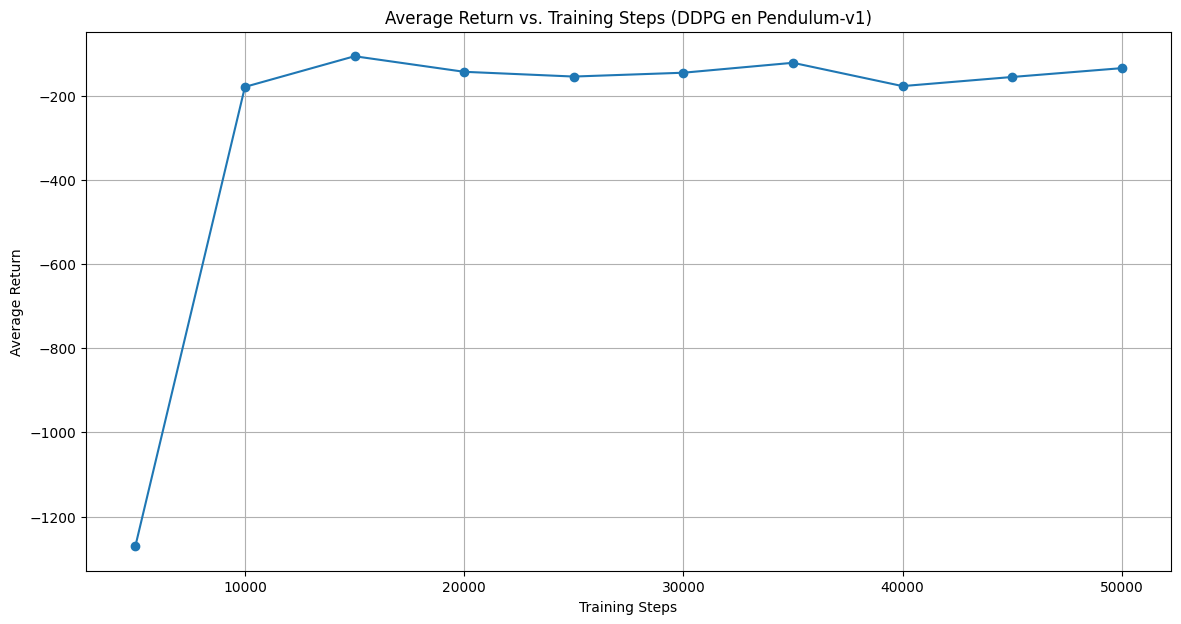


Generando video del agente entrenado...
Generando video del agente aleatorio...

--- Video: Agente Entrenado (Política DDPG) ---



--- Video: Agente Aleatorio (Política Aleatoria) ---


In [10]:
# ===================================================================
# Visualización y Generación de Entregables
# ===================================================================

# 1. Generar la gráfica de la recompensa promedio.
steps, avg_returns = zip(*returns)
plt.figure(figsize=(14, 7))
plt.plot(steps, avg_returns, marker='o', linestyle='-')
plt.ylabel('Average Return')
plt.xlabel('Training Steps')
plt.title('Average Return vs. Training Steps (DDPG en Pendulum-v1)')
plt.grid(True)
plt.show()

# --- Funciones para Video (Optimizadas) ---

def create_policy_eval_video(policy, filename, eval_tf_env, eval_py_env, num_episodes=1, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      tf_time_step = eval_tf_env.reset()
      video.append_data(eval_py_env.render())
      while not tf_time_step.is_last():
        action_step = policy.action(tf_time_step)
        tf_time_step = eval_tf_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return filename

def embed_mp4(filename):
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = f'''<video width="640" height="480" controls><source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4"></video>'''
  # Importante: embed_mp4 ahora devuelve el objeto HTML, no lo muestra
  return IPython.display.HTML(tag)

# --- Generar y Mostrar Videos (CORREGIDO) ---
print("\nGenerando video del agente entrenado...")
trained_video_path = create_policy_eval_video(agent.policy, "trained-agent", eval_tf_env, eval_py_env)

print("Generando video del agente aleatorio...")
random_policy_for_video = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
random_video_path = create_policy_eval_video(random_policy_for_video, "random-agent", eval_tf_env, eval_py_env)

# Usamos IPython.display.display para evitar el conflicto de nombres
print("\n--- Video: Agente Entrenado (Política DDPG) ---")
IPython.display.display(embed_mp4(trained_video_path))

print("\n--- Video: Agente Aleatorio (Política Aleatoria) ---")
IPython.display.display(embed_mp4(random_video_path))